<a href="https://colab.research.google.com/github/Lezginchik64/Colab_Projects/blob/main/%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8_%D0%A0%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BE%D0%B4%D0%B5%D0%B6%D0%B4%D1%8B_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Навигация по уроку**

1. [Краткая история нейронных сетей. Знакомство с многослойным персептроном](https://colab.research.google.com/drive/1-FEYLgNSN5kJyAOoaW9dOhDUABU8VJlc)
2. [Математический аппарат обучения нейронных сетей](https://colab.research.google.com/drive/1FtyyBXYq9FaOEknvu4ghim-ejuO_3aIZ)
3. [Обучение многослойного персептрона в TensorFlow (Практика)](https://colab.research.google.com/drive/1Q8ioc9pkkaqGravu37C7jKw9OaG7cNL0)
4. Домашняя работа

Используя модель обучения многослойного персептрона из практической части урока (9.3), выполните следующее:

1. Увеличьте число слоев до 4-х и сравните время обучения модели и точность на тестовой выборке.
2. В качестве датасета использовать любой из наборов данных TensorFlow. Обучить модель. Добейтесь результата распознования более 85% на тестовой выборке. [Датасеты на выбор](https://www.tensorflow.org/datasets/overview). Используйте датасет отличный от MNIST, который был в уроке.

Для прохождения урока достаточно решить первое задание.

# 1 Задание

In [ ]:
!pip install -q seaborn

In [ ]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import tempfile
import os
matplotlib.rcParams['figure.figsize'] = [9, 6]
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
train_data, val_data, test_data = tfds.load("mnist",
                                            split=['train[10000:]', 'train[0:10000]', 'test'],
                                            batch_size=128, as_supervised=True)

Размерность исходных данных: (1500, 28, 28, 1)
Размерность данных после сжатия: (1500, 28, 28)


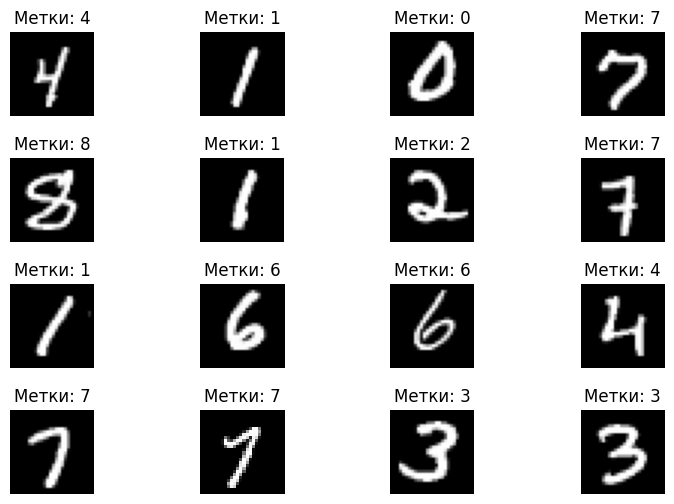

In [ ]:
x_viz, y_viz = tfds.load("mnist", split=['train[:1500]'], batch_size=-1, as_supervised=True)[0] # Взять все одним батчем и выбрать его для визуализации
print('Размерность исходных данных:', x_viz.shape)
x_viz = tf.squeeze(x_viz, axis=3) # метод сжатия размерности, исключаем данные по оси с индексом 3
print('Размерность данных после сжатия:', x_viz.shape)

for i in range(16): # Выводим 16 картинок из датасета
    plt.subplot(4,4,1+i)
    plt.axis('off')
    plt.imshow(x_viz[i], cmap='gray') # отображение массива numpy как картинки; cmap - карта цветов, используем серую 'gray'
    plt.title(f"Метки: {y_viz[i]}")
    plt.subplots_adjust(hspace=.5, wspace=.5) # Отступы по ширине и высоте между картинками

In [ ]:
# Функция изменения формы и масштабирования данных
def preprocess(x, y):
  # reshap - изменяет форму данных
  x = tf.reshape(x, shape=(-1, 784)) # -1 - значит сохранить форму для заданного индекса матрицы, равносильно указать 1500
  # Масштабируем данные
  x = x/255
  return x, y

train_data, val_data = train_data.map(preprocess), val_data.map(preprocess) # map выполняет функцию preprocess для каждого элемента данных, к которым применяется

Text(0.5, 1.0, 'Функция активации ReLU')

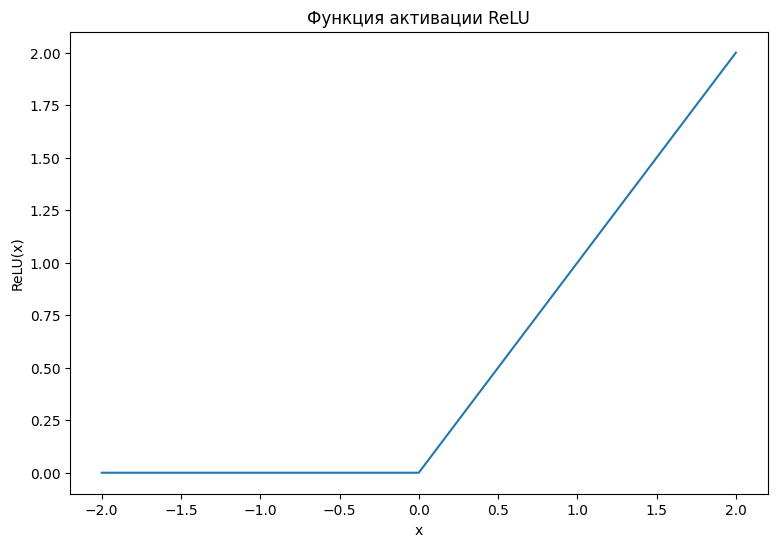

In [ ]:
x = tf.linspace(-2, 2, 201) # Тензорный вариант для linspace
x = tf.cast(x, tf.float32) # Приведение тензора к нужному типу, в данном случае к 32-х разрядному числу с плавающей точкой
plt.plot(x, tf.nn.relu(x))
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.title('Функция активации ReLU')

Text(0.5, 1.0, 'Функция активации Softmax')

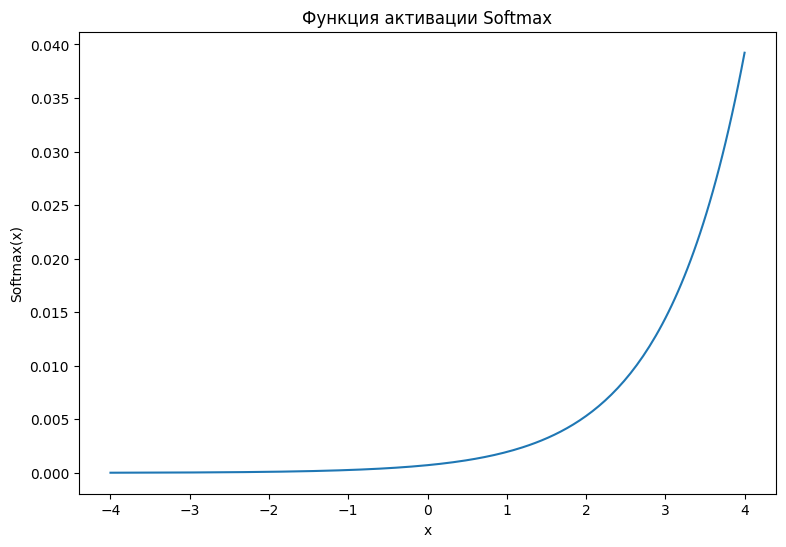

In [ ]:
x = tf.linspace(-4, 4, 201)
x = tf.cast(x, tf.float32)
plt.plot(x, tf.nn.softmax(x, axis=0)) # указываем ось (axis), индекс тензора, по которому проводим вычисления
plt.xlabel('x')
plt.ylabel('Softmax(x)')
plt.title('Функция активации Softmax')

In [ ]:
def xavier_init(shape):
  # Вычисляем значения инициализации xavier для весовой матрицы
  in_dim, out_dim = shape

  # Задаем диапазон инициализации весов по схеме Ксавье
  xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))

  # Возвращаем тензор с равномерно распределенными случайными величинами в указанном интервале.
  weight_vals = tf.random.uniform(shape=(in_dim, out_dim),
                                  minval=-xavier_lim, maxval=xavier_lim)
  return weight_vals

In [ ]:
class DenseLayer(tf.Module):

  def __init__(self, out_dim, weight_init=xavier_init, activation=tf.identity):
    # Инициализация размеров и функции активации
    self.out_dim = out_dim # Определяем размерность выходов
    self.weight_init = weight_init # Инициализируем веса
    self.activation = activation # Задаем функцию активации
    self.built = False

  @tf.function # Декоратор, который переносит вычисления на уровень графа TensorFlow
  def __call__(self, x):
    if not self.built: # Если запущен первый раз проводим инициализацию
      # Вывод входного измерения на основе первого вызова
      self.in_dim = x.shape[1]
      # Инициализация весов и смещений
      self.w = tf.Variable(self.weight_init(shape=(self.in_dim, self.out_dim))) # Объявление тензорных переменных
      self.b = tf.Variable(tf.zeros(shape=(self.out_dim,))) # Объявление тензорных переменных
      self.built = True # Инициализация пройдена
    # Вычисление прямого прохода
    y = tf.add(tf.matmul(x, self.w), self.b)  # уравнение персептрона
    return self.activation(y) # Применение функции активации к уравнению персептрона

In [ ]:
class MLP(tf.Module):

  def __init__(self, layers):
    self.layers = layers

  @tf.function # Декоратор, который переносит вычисления на уровень графа TensorFlow
  def __call__(self, x, preds=False):
    # Последовательное выполнение слоев модели
    for layer in self.layers:
      x = layer(x)
    return x

In [ ]:
hidden_layer_1_size = 700
hidden_layer_2_size = 500
output_size = 10

# Создание модели нейронной сети
mlp_model = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.relu),
    DenseLayer(out_dim=output_size)])

In [ ]:
def cross_entropy_loss(y_pred, y):
  # Вычисление перекрестной энтропии с помощью разреженной операции
  sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(sparse_ce) # аналог np.mean для тензоров

In [ ]:
def accuracy(y_pred, y):
  # Вычисляем точность после извлечения предсказаний класса
  class_preds = tf.argmax(tf.nn.softmax(y_pred), axis=1) # возвращает индекс максимального элемента
  is_equal = tf.equal(y, class_preds) # сравнение тензорных значений
  return tf.reduce_mean(tf.cast(is_equal, tf.float32)) # аналог np.mean для тензоров

In [ ]:
class Adam:

    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
      # Инициализируем параметры оптимизатора и резервируем переменные
      self.beta_1 = beta_1 # гиперпараметр
      self.beta_2 = beta_2 # гиперпараметр
      self.learning_rate = learning_rate # шаг обучения
      self.ep = ep # Эпсилон - предотвращает деление на ноль, слабо влияет на обучение
      self.t = 1.
      self.v_dvar, self.s_dvar = [], []
      self.built = False

    def apply_gradients(self, grads, vars):
      # Инициализируем переменные при первом вызове
      if not self.built:
        for var in vars:
          v = tf.Variable(tf.zeros(shape=var.shape))
          s = tf.Variable(tf.zeros(shape=var.shape))
          self.v_dvar.append(v)
          self.s_dvar.append(s)
        self.built = True
      # Обновите переменные модели с учетом их градиентов
      for i, (d_var, var) in enumerate(zip(grads, vars)):
        self.v_dvar[i].assign(self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var)
        self.s_dvar[i].assign(self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var))
        v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
        s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
        var.assign_sub(self.learning_rate*(v_dvar_bc/(tf.sqrt(s_dvar_bc) + self.ep)))
      self.t += 1.
      return

In [ ]:
def train_step(x_batch, y_batch, loss, acc, model, optimizer):
  # Обновляем состояние модели с учетом пакета данных
  with tf.GradientTape() as tape:
    y_pred = model(x_batch) # Предсказываем значение с текущими весами
    batch_loss = loss(y_pred, y_batch) # Оцениваем ошибку на текущих весах
  batch_acc = acc(y_pred, y_batch) # Оцениваем точность на текущих весах
  grads = tape.gradient(batch_loss, model.variables) # Вычисляем градиенты
  optimizer.apply_gradients(grads, model.variables) # Обновляем переменные с учетом полученных градиентов
  return batch_loss, batch_acc # Возвращаем ошибку и точность на основе заданного пакета

def val_step(x_batch, y_batch, loss, acc, model):
  # Оцениваем модель на основе заданного пакета валидационных данных без обучения на текущих весах
  y_pred = model(x_batch)
  batch_loss = loss(y_pred, y_batch)
  batch_acc = acc(y_pred, y_batch)
  return batch_loss, batch_acc

In [ ]:
def train_model(mlp, train_data, val_data, loss, acc, optimizer, epochs):
  # Инициализация структур данных
  train_losses, train_accs = [], []
  val_losses, val_accs = [], []

  # Отформатируем тренировочный цикл и начнем обучение
  for epoch in range(epochs):
    batch_losses_train, batch_accs_train = [], []
    batch_losses_val, batch_accs_val = [], []

    # Выполняем итерацию по обучающим данным
    for x_batch, y_batch in train_data:
      # Вычисляем градиенты и обновляем параметры модели
      batch_loss, batch_acc = train_step(x_batch, y_batch, loss, acc, mlp, optimizer)
      # Следим за результатами обучения на пакетном уровне
      batch_losses_train.append(batch_loss)
      batch_accs_train.append(batch_acc)

    # Повторяем процедуру проверки данных
    for x_batch, y_batch in val_data:
      batch_loss, batch_acc = val_step(x_batch, y_batch, loss, acc, mlp)
      batch_losses_val.append(batch_loss)
      batch_accs_val.append(batch_acc)

    # Следим за производительностью модели на уровне эпохи
    train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
    val_loss, val_acc = tf.reduce_mean(batch_losses_val), tf.reduce_mean(batch_accs_val)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Эпоха: {epoch}")
    print(f"Обучающая ошибка: {train_loss:.3f}, Обучающая точность: {train_acc:.3f}")
    print(f"Валидационная ошибка: {val_loss:.3f}, Валидационная точность: {val_acc:.3f}")
  return train_losses, train_accs, val_losses, val_accs

In [ ]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data, val_data,
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=Adam(), epochs=10)

Эпоха: 0
Обучающая ошибка: 0.221, Обучающая точность: 0.935
Валидационная ошибка: 0.123, Валидационная точность: 0.963
Эпоха: 1
Обучающая ошибка: 0.081, Обучающая точность: 0.975
Валидационная ошибка: 0.097, Валидационная точность: 0.972
Эпоха: 2
Обучающая ошибка: 0.047, Обучающая точность: 0.986
Валидационная ошибка: 0.084, Валидационная точность: 0.975
Эпоха: 3
Обучающая ошибка: 0.033, Обучающая точность: 0.989
Валидационная ошибка: 0.105, Валидационная точность: 0.973
Эпоха: 4
Обучающая ошибка: 0.027, Обучающая точность: 0.991
Валидационная ошибка: 0.106, Валидационная точность: 0.973
Эпоха: 5
Обучающая ошибка: 0.022, Обучающая точность: 0.993
Валидационная ошибка: 0.087, Валидационная точность: 0.977
Эпоха: 6
Обучающая ошибка: 0.019, Обучающая точность: 0.993
Валидационная ошибка: 0.102, Валидационная точность: 0.977
Эпоха: 7
Обучающая ошибка: 0.015, Обучающая точность: 0.995
Валидационная ошибка: 0.094, Валидационная точность: 0.979
Эпоха: 8
Обучающая ошибка: 0.016, Обучающая точн

In [ ]:
# Новый размер скрытых слоев
hidden_layer_3_size = 300
hidden_layer_4_size = 200

# Создание новой модели с 4 скрытыми слоями
mlp_model_4_layers = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_3_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_4_size, activation=tf.nn.relu),
    DenseLayer(out_dim=output_size)])

In [ ]:
# Обучение новой модели
train_losses_4, train_accs_4, val_losses_4, val_accs_4 = train_model(
    mlp_model_4_layers, train_data, val_data,
    loss=cross_entropy_loss, acc=accuracy,
    optimizer=Adam(), epochs=10)

Эпоха: 0
Обучающая ошибка: 0.236, Обучающая точность: 0.929
Валидационная ошибка: 0.117, Валидационная точность: 0.967
Эпоха: 1
Обучающая ошибка: 0.089, Обучающая точность: 0.973
Валидационная ошибка: 0.124, Валидационная точность: 0.964
Эпоха: 2
Обучающая ошибка: 0.057, Обучающая точность: 0.982
Валидационная ошибка: 0.099, Валидационная точность: 0.974
Эпоха: 3
Обучающая ошибка: 0.048, Обучающая точность: 0.985
Валидационная ошибка: 0.104, Валидационная точность: 0.974
Эпоха: 4
Обучающая ошибка: 0.041, Обучающая точность: 0.987
Валидационная ошибка: 0.121, Валидационная точность: 0.969
Эпоха: 5
Обучающая ошибка: 0.034, Обучающая точность: 0.989
Валидационная ошибка: 0.103, Валидационная точность: 0.973
Эпоха: 6
Обучающая ошибка: 0.025, Обучающая точность: 0.993
Валидационная ошибка: 0.095, Валидационная точность: 0.976
Эпоха: 7
Обучающая ошибка: 0.022, Обучающая точность: 0.994
Валидационная ошибка: 0.104, Валидационная точность: 0.976
Эпоха: 8
Обучающая ошибка: 0.027, Обучающая точн

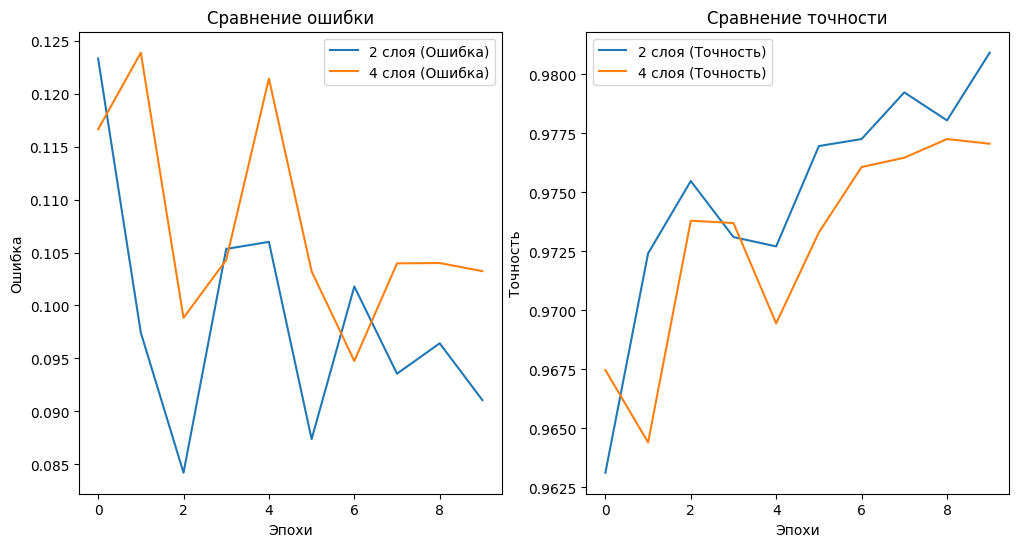

In [ ]:
# Визуализация ошибок и точности
epochs = range(10)

# Сравнение ошибки
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, val_losses, label='2 слоя (Ошибка)')
plt.plot(epochs, val_losses_4, label='4 слоя (Ошибка)')
plt.xlabel('Эпохи')
plt.ylabel('Ошибка')
plt.title('Сравнение ошибки')
plt.legend()

# Сравнение точности
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accs, label='2 слоя (Точность)')
plt.plot(epochs, val_accs_4, label='4 слоя (Точность)')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.title('Сравнение точности')
plt.legend()
plt.show()

# 2 Задание

In [ ]:
train_data, val_data, test_data = tfds.load("fashion_mnist",
                                            split=['train[10000:]', 'train[0:10000]', 'test'],
                                            batch_size=128, as_supervised=True)

In [ ]:
x_viz, y_viz = tfds.as_numpy(tfds.load("fashion_mnist", split='train[:16]', batch_size=-1, as_supervised=True))

In [ ]:
# Метки классов
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

Размерность данных до сжатия: (1500, 28, 28, 1)
Размерность данных после сжатия: (1500, 28, 28)


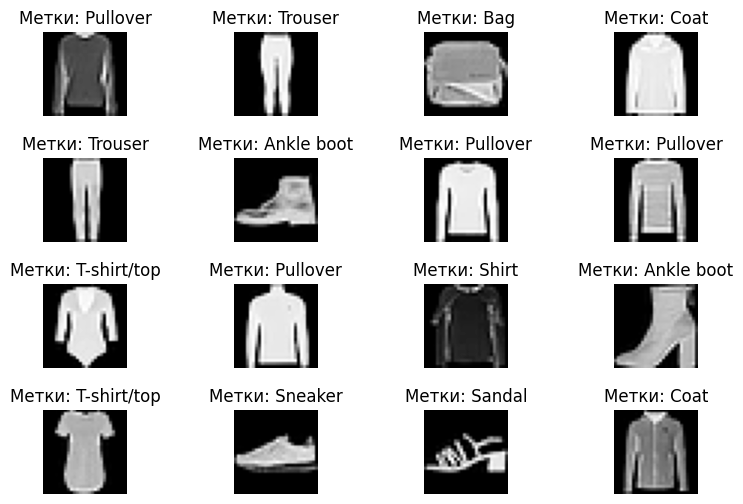

In [ ]:
x_viz, y_viz = tfds.load("fashion_mnist", split=['train[:1500]'], batch_size=-1, as_supervised=True)[0]
print('Размерность данных до сжатия:', x_viz.shape)
x_viz = tf.squeeze(x_viz, axis=3)
print('Размерность данных после сжатия:', x_viz.shape)
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.axis('off')
    plt.imshow(x_viz[i], cmap='gray')
    plt.title(f"Метки: {class_names[int(y_viz[i])]}")
    plt.subplots_adjust(hspace=.5, wspace=.5)
plt.show()

In [ ]:
# Применяем функцию предобработки
train_data = train_data.map(preprocess)
val_data = val_data.map(preprocess)
test_data = test_data.map(preprocess)

In [ ]:
# Визуализация функций активации
x = tf.linspace(-2.0, 2.0, 201)
x = tf.cast(x, tf.float32)

In [ ]:
class MLP(tf.Module):

  def __init__(self, layers):
    self.layers = layers

  @tf.function
  def __call__(self, x, preds=False):
    for layer in self.layers:
      x = layer(x)
    return x

hidden_layer_1_size = 700
hidden_layer_2_size = 500
output_size = 10

mlp_model = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.relu),
    DenseLayer(out_dim=output_size)])

def cross_entropy_loss(y_pred, y):
  sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(sparse_ce)

def accuracy(y_pred, y):
  class_preds = tf.argmax(tf.nn.softmax(y_pred), axis=1)
  is_equal = tf.equal(y, class_preds)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

In [ ]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data, val_data,
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=Adam(), epochs=10)

Эпоха: 0
Обучающая ошибка: 0.482, Обучающая точность: 0.826
Валидационная ошибка: 0.404, Валидационная точность: 0.853
Эпоха: 1
Обучающая ошибка: 0.356, Обучающая точность: 0.869
Валидационная ошибка: 0.344, Валидационная точность: 0.876
Эпоха: 2
Обучающая ошибка: 0.319, Обучающая точность: 0.883
Валидационная ошибка: 0.336, Валидационная точность: 0.876
Эпоха: 3
Обучающая ошибка: 0.294, Обучающая точность: 0.891
Валидационная ошибка: 0.342, Валидационная точность: 0.873
Эпоха: 4
Обучающая ошибка: 0.273, Обучающая точность: 0.898
Валидационная ошибка: 0.346, Валидационная точность: 0.874
Эпоха: 5
Обучающая ошибка: 0.254, Обучающая точность: 0.906
Валидационная ошибка: 0.328, Валидационная точность: 0.881
Эпоха: 6
Обучающая ошибка: 0.241, Обучающая точность: 0.910
Валидационная ошибка: 0.351, Валидационная точность: 0.881
Эпоха: 7
Обучающая ошибка: 0.229, Обучающая точность: 0.914
Валидационная ошибка: 0.344, Валидационная точность: 0.882
Эпоха: 8
Обучающая ошибка: 0.216, Обучающая точн

In [ ]:
def plot_metrics(train_metric, val_metric, metric_type):
  # Визуализация метрик в зависимости от эпох обучения
  plt.figure()
  plt.plot(range(len(train_metric)), train_metric, label = f"{metric_type} на обучающей выборке")
  plt.plot(range(len(val_metric)), val_metric, label = f"{metric_type} на валидационной выборке")
  plt.xlabel("Эпохи")
  plt.ylabel(metric_type)
  plt.legend()
  plt.title(f"{metric_type} от эпохи");

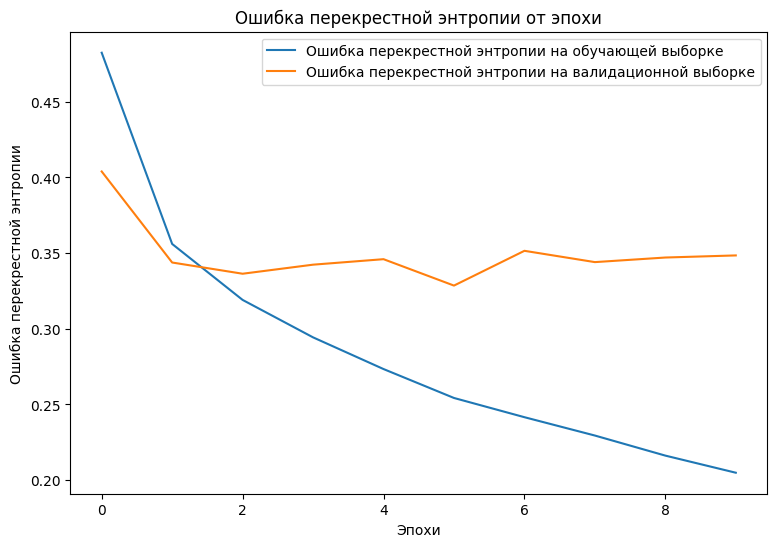

In [ ]:
plot_metrics(train_losses, val_losses, "Ошибка перекрестной энтропии")

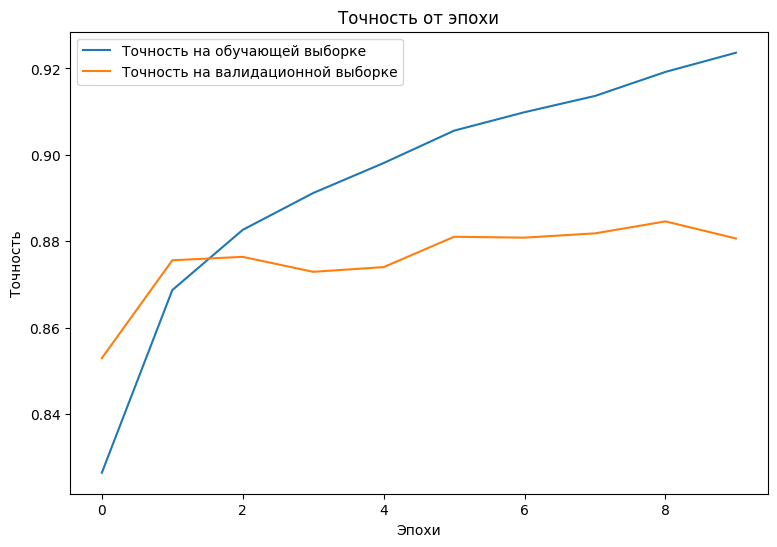

In [ ]:
plot_metrics(train_accs, val_accs, "Точность")